# Validation

In [1]:
import os
import glob
import re
import torch
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn
from torchvision import transforms, datasets
from tqdm import tqdm
from PIL import Image

from networks.resnet_big import SupConResNet, model_dict
from util_logging import add_tsne_to_run_md

seaborn.set_theme(style="darkgrid")

### Parameters

In [15]:
cuda_device = 1
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

# dataset
root_train = "./datasets/animals10_300x300/train/"
root_test = "./datasets/animals10_300x300/test/"
mean = (0.3837, 0.3704, 0.3072)
std = (0.3268, 0.3187, 0.3051)

# model checkpoint to validate
# root_model = "./save/SupCon/cifar10/SupCon_cifar10_resnet50_lr_0.5_decay_0.0001_bsz_400_temp_0.1_trial_0_cosine_warm/models/last.pth"

# root_model = "./save/SupCon/animals10/SupCon_animals10_resnet18_lr_0.5_decay_0.0001_bsz_26_temp_0.1_trial_0_try2_cosine/models/ckpt_epoch_250.pth"
root_model = "./save/SupCon/animals10/SupCon_animals10_resnet18_lr_0.5_decay_0.0001_bsz_26_temp_0.1_trial_0_try2_cosine/models/last.pth"

# root_model = "./save/SupCon/animals10/SupCon_animals10_resnet18_lr_0.5_decay_0.0001_bsz_16_temp_0.1_trial_0_CropSize32_cosine/models/last.pth"

In [16]:
tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

path = root_model.split('/')

for i in range(len(path)):
    if re.fullmatch(
        ".+_.+_lr_[0-9]+(\.[0-9]+)?_decay_[0-9]+\.[0-9]+_bsz_[1-9][0-9]*_temp_[0-9]+(\.[0-9]+)?_trial_[0-9]+(_.+)*",
        path[i]) != None:
        break

# check if checkpoint is in folder with correct name to determent params
assert i < len(path)-1

params = dict()

model_folder = path[i]
folder_split = model_folder.split('_')
params['mode'] = folder_split[0]
params['dataset'] = folder_split[1]
params['model_name'] = folder_split[2]

for j in range(3,13,2):
    params[folder_split[j]] = int(folder_split[j+1]) if (folder_split[j] in ['bsz', 'trial']) else float(folder_split[j+1])

for f in folder_split[13:]:
    params[f] = True

epoch = path[-1].replace(".pth", '').split('_')[-1]

# path_embeddings = os.path.join("./save/embeddings/", params['dataset'], model_folder, f"epoch_{epoch}")# TODO remove old save structure
path_run_md = os.path.join(*path[:i+1])
path_embeddings = os.path.join(path_run_md, f"val_{epoch}", "embeddings")

### Dataloader and Model

In [17]:
if params['dataset'] == 'cifar10':
    root_train = "./datasets/"
    root_test = "./datasets/"
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
elif params['dataset'] == 'cifar100':
    root_train = "./datasets/"
    root_test = "./datasets/"
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

normalize = transforms.Normalize(mean=mean, std=std)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

if params['dataset'] == 'cifar10':
    train_dataset = datasets.CIFAR10(root=root_train,
                                     transform=val_transform,
                                     download=True)
    val_dataset = datasets.CIFAR10(root=root_test,
                                   train=False,
                                   transform=val_transform)
elif params['dataset'] == 'cifar100':
    train_dataset = datasets.CIFAR100(root=root_train,
                                      transform=val_transform,
                                      download=True)
    val_dataset = datasets.CIFAR100(root=root_test,
                                    train=False,
                                    transform=val_transform)
else:
# elif params['dataset'] == 'path':# TODO remove "path dataset"
    train_dataset = datasets.ImageFolder(root=root_train,
                                         transform=val_transform)
    val_dataset = datasets.ImageFolder(root=root_test,
                                       transform=val_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=params['bsz'], shuffle=False,
    num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=params['bsz'], shuffle=False,
    num_workers=8, pin_memory=True)

In [18]:
model = SupConResNet(name=params['model_name'])

ckpt = torch.load(root_model, map_location='cpu')
state_dict = ckpt['model']

new_state_dict = {}
for k, v in state_dict.items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
state_dict = new_state_dict

model = model.cuda(device=cuda_device)

model.load_state_dict(state_dict)

<All keys matched successfully>

### Compute Embedding

In [19]:
if not os.path.isdir(path_embeddings):
    os.makedirs(path_embeddings)

_, embedding_size = model_dict[params['model_name']]

model.eval()

embedding = np.array([])
class_labels = np.array([], dtype=int)
for idx, (images, labels) in enumerate(tqdm(train_loader)):
    images = images.cuda(device=cuda_device, non_blocking=True)

    with torch.no_grad():
        features = model.encoder(images)

    embedding = np.append(embedding, features.cpu().numpy())
    class_labels = np.append(class_labels, labels.numpy())


embedding = embedding.reshape(-1, embedding_size)

entry = {'data': embedding, 'labels': class_labels}
with open(os.path.join(path_embeddings, "embedding_train"), 'wb') as f:
    pickle.dump(entry, f, protocol=-1)


embedding = np.array([])
class_labels = np.array([], dtype=int)
for idx, (images, labels) in enumerate(tqdm(val_loader)):
    images = images.cuda(device=cuda_device, non_blocking=True)

    with torch.no_grad():
        features = model.encoder(images)

    embedding = np.append(embedding, features.cpu().numpy())
    class_labels = np.append(class_labels, labels.numpy())

embedding = embedding.reshape(-1, embedding_size)

entry = {'data': embedding, 'labels': class_labels}
with open(os.path.join(path_embeddings, "embedding_test"), 'wb') as f:
    pickle.dump(entry, f, protocol=-1)

model = model.cpu()

  0%|          | 0/806 [00:00<?, ?it/s]

100%|██████████| 202/202 [01:05<00:00,  3.07it/s]


### t-SNE

In [20]:
!CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings}

Training data
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Test data
load feature embedding
compute t-SNE embedding
writ t-SNE embedding


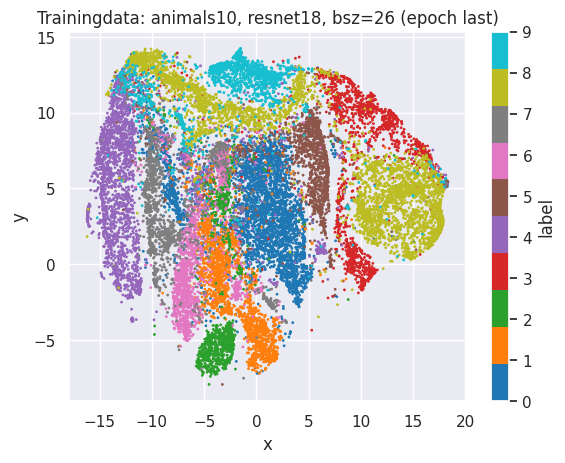

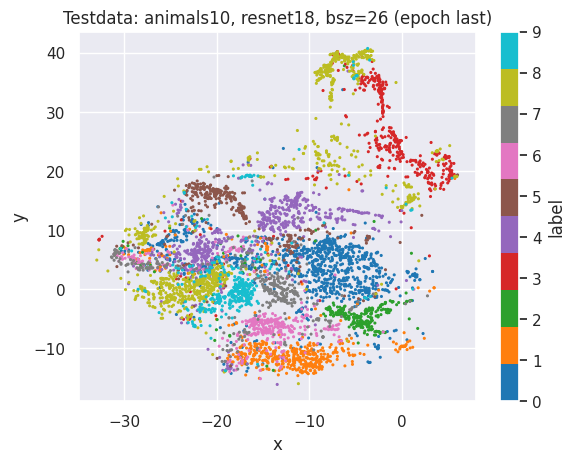

In [21]:
save_plot = True

with open(os.path.join(path_embeddings, "embedding_tSNE_train"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_train = entry['data']
    labels_train = entry['labels']
df_train = pd.DataFrame.from_dict({'x': embedding_tSNE_train[:,0], 'y': embedding_tSNE_train[:,1], 'label': labels_train})

with open(os.path.join(path_embeddings, "embedding_tSNE_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_test = entry['data']
    labels_test = entry['labels']
df_test = pd.DataFrame.from_dict({'x': embedding_tSNE_test[:,0], 'y': embedding_tSNE_test[:,1], 'label': labels_test})

if save_plot:
    df_train.plot.scatter(x='x', y='y', c='label', colormap='tab10', s=1,
                          title=f"Trainingdata: {params['dataset']}, {params['model_name']}, bsz={params['bsz']} (epoch {epoch})"
                          ).get_figure().savefig(os.path.join(path_embeddings, f"tSNE_epoch_{epoch}_train.png"))
    df_test.plot.scatter(x='x', y='y', c='label', colormap='tab10', s=1.5,
                         title=f"Testdata: {params['dataset']}, {params['model_name']}, bsz={params['bsz']} (epoch {epoch})"
                         ).get_figure().savefig(os.path.join(path_embeddings, f"tSNE_epoch_{epoch}_test.png"))
    
    add_tsne_to_run_md(path=path_run_md, epoch=epoch)
else:
    fig, axs = plt.subplots(nrows=2, figsize=(7, 10))
    df_train.plot.scatter(x='x', y='y', c='label', colormap='tab10', s=1, ax=axs[0],
                        title=f"Trainingdata: {params['dataset']}, {params['model_name']}, bsz={params['bsz']} (epoch {epoch})")
    df_test.plot.scatter(x='x', y='y', c='label', colormap='tab10', s=1.5, ax=axs[1],
                        title=f"Testdata: {params['dataset']}, {params['model_name']}, bsz={params['bsz']} (epoch {epoch})")

### Classifier

In [22]:
classifier_training_call = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                          + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                          + f" --model {params['model_name']} --dataset {params['dataset']}"\
                          + f" --data_folder {os.path.join(path_embeddings, 'embedding_train')}"\
                          + f" --test_folder {os.path.join(path_embeddings, 'embedding_test')}"\
                          + " --num_classes 10 --pre_comp_feat"\
                          + f" --tag Epoch{epoch}"\
                          + " > precomp_classifier.out"

In [23]:
!{classifier_training_call}

nohup: ignoring input and redirecting stderr to stdout


In [24]:
# move precomp_classifier.out to the classifier directory
path_classifier = glob.glob(os.path.join(path_run_md, f"val_{epoch}", "classifier", "*/"))
if len(path_classifier) > 0:
    path_classifier = path_classifier[0]

os.makedirs(os.path.join(path_classifier, "out"), exist_ok=True)

os.replace("precomp_classifier.out", os.path.join(path_classifier, "out", "precomp_classifier.out"))

(-0.5, 639.5, 479.5, -0.5)

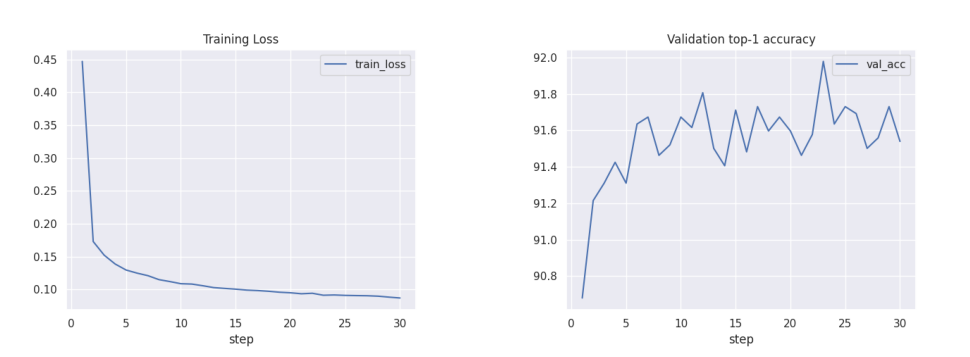

In [25]:
# load plots of classifier Training Loss and Validation Accuracy
train_loss_plot = Image.open(os.path.join(path_classifier, "tensorboard", "train_loss.png"))
val_top1_plot = Image.open(os.path.join(path_classifier, "tensorboard", "val_top1.png"))

fig, axs = plt.subplots(ncols=2, figsize=(10,6))
fig.tight_layout(pad=0)
axs[0].imshow(np.array(train_loss_plot))
axs[0].axis('off')
axs[1].imshow(np.array(val_top1_plot))
axs[1].axis('off')